# Liver Cirrhosis Detection using MRI + Metadata
*Enhanced model combining MRI images and patient metadata (Age, Gender)*

In [1]:
# Cell 1: Imports and Configuration
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = (128, 128, 64)
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.001

In [2]:
# Cell 2: Utility Functions
def load_nii(filepath):
    """Load a NIfTI file and return a NumPy array."""
    nii_img = nib.load(filepath)
    return nii_img.get_fdata()

def preprocess_volume(volume, target_size):
    """Resize and normalize the 3D volume."""
    # Calculate zoom factors for each dimension
    zoom_factors = [target_size[i] / volume.shape[i] for i in range(3)]
    
    # Resize volume using cubic interpolation
    resized_volume = zoom(volume, zoom_factors, order=1)
    
    # Normalize to [0, 1]
    resized_volume = (resized_volume - resized_volume.min()) \
                    / (resized_volume.max() - resized_volume.min())
    
    return resized_volume.astype(np.float32)
def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix with labels."""
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [3]:
# Cell 3: Dataset Class
class LiverMRIMetaDataset(Dataset):
    def __init__(self, cirrhosis_dir, healthy_dir, cirrhosis_meta, healthy_meta):
        self.samples = []
        # Load cirrhosis cases
        for fname in os.listdir(cirrhosis_dir):
            if fname.endswith(".nii"):
                try:
                    pid = int(fname.split("_")[0].replace("Pat", "").replace(".nii", ""))
                except:
                    continue
                row = cirrhosis_meta[cirrhosis_meta['Patient ID'] == pid]
                if not row.empty:
                    img_path = os.path.join(cirrhosis_dir, fname)
                    age = row.iloc[0]['Age']
                    gender = row.iloc[0]['Gender']
                    label = 1
                    self.samples.append((img_path, age, gender, label))

        # Load healthy cases
        for fname in os.listdir(healthy_dir):
            if fname.endswith(".nii"):
                try:
                    pid = int(fname.replace(".nii", ""))
                except:
                    continue
                row = healthy_meta[healthy_meta['ID'] == pid]
                if not row.empty:
                    img_path = os.path.join(healthy_dir, fname)
                    age = row.iloc[0]['Age']
                    gender = row.iloc[0]['Gender']
                    label = 0
                    self.samples.append((img_path, age, gender, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, age, gender, label = self.samples[idx]
        img = load_nii(img_path)
        img = preprocess_volume(img, IMG_SIZE)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.tensor(img, dtype=torch.float32)
        meta_tensor = torch.tensor([age / 100, gender], dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_tensor, meta_tensor, label

In [4]:
# Cell 4: Load Metadata
cirrhosis_meta = pd.read_csv("Metadata/CirrMRI600+_CompleteData_age_gender_evaluation.csv")
healthy_meta = pd.read_csv("Metadata/Healthy_demographics.csv")

# Clean column names
cirrhosis_meta.columns = cirrhosis_meta.columns.str.strip()
healthy_meta.columns = healthy_meta.columns.str.strip()

In [5]:
# Cell 5: Create DataLoaders
from torch.utils.data import random_split

dataset = LiverMRIMetaDataset(
    cirrhosis_dir="cirrhosis_T1_3D/train_images",
    healthy_dir="T1_W_Healthy/T1_images",
    cirrhosis_meta=cirrhosis_meta,
    healthy_meta=healthy_meta
)

# Train-test split
total_size = len(dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [6]:
# Cell 6: Model Definition
class CNNWithMetadata(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)

        # Calculate flattened size
        dummy = torch.zeros(1, 1, *IMG_SIZE)
        dummy = self.pool(F.relu(self.conv1(dummy)))
        dummy = self.pool(F.relu(self.conv2(dummy)))
        self.flat_size = dummy.view(1, -1).shape[1]

        # Combined classifier
        self.fc1 = nn.Linear(self.flat_size + 2, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, img, meta):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.cat([x, meta], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
# Enhanced Training with Validation Tracking
model = CNNWithMetadata().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []  # <-- New: track training accuracy
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    epoch_train_loss = 0
    train_preds = []  # <-- New
    train_labels = []  # <-- New
    
    for img, meta, label in tqdm(train_loader):
        img, meta, label = img.to(DEVICE), meta.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(img, meta)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        
        # <-- New: compute predictions for accuracy
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(label.cpu().numpy())

    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(train_labels, train_preds)  # <-- New
    train_accuracies.append(train_accuracy)  # <-- New

    # Validation Phase
    model.eval()
    epoch_val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for img, meta, label in test_loader:
            img, meta, label = img.to(DEVICE), meta.to(DEVICE), label.to(DEVICE)
            outputs = model(img, meta)
            loss = criterion(outputs, label)
            epoch_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    # Calculate Metrics
    val_loss = epoch_val_loss / len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2%}")

# Save final model
torch.save(model.state_dict(), "cirrhosis_cnn_metadata_model.pth")


100%|██████████| 61/61 [04:50<00:00,  4.77s/it]


Epoch 1/10
Train Loss: 1.1612 | Train Acc: 75.31% | Val Loss: 0.5435 | Val Acc: 76.67%


100%|██████████| 61/61 [04:46<00:00,  4.69s/it]


Epoch 2/10
Train Loss: 0.4546 | Train Acc: 83.13% | Val Loss: 0.4615 | Val Acc: 76.67%


100%|██████████| 61/61 [05:00<00:00,  4.93s/it]


Epoch 3/10
Train Loss: 0.4278 | Train Acc: 83.54% | Val Loss: 0.4948 | Val Acc: 80.00%


100%|██████████| 61/61 [03:55<00:00,  3.87s/it]


Epoch 4/10
Train Loss: 0.3521 | Train Acc: 86.83% | Val Loss: 0.4349 | Val Acc: 78.33%


100%|██████████| 61/61 [04:46<00:00,  4.70s/it]


Epoch 5/10
Train Loss: 0.3609 | Train Acc: 83.13% | Val Loss: 0.3925 | Val Acc: 83.33%


100%|██████████| 61/61 [05:05<00:00,  5.00s/it]


Epoch 6/10
Train Loss: 0.3193 | Train Acc: 86.01% | Val Loss: 0.4100 | Val Acc: 78.33%


100%|██████████| 61/61 [04:38<00:00,  4.56s/it]


Epoch 7/10
Train Loss: 0.2326 | Train Acc: 91.36% | Val Loss: 0.3441 | Val Acc: 83.33%


100%|██████████| 61/61 [05:12<00:00,  5.12s/it]


Epoch 8/10
Train Loss: 0.2340 | Train Acc: 88.48% | Val Loss: 0.4980 | Val Acc: 75.00%


100%|██████████| 61/61 [04:26<00:00,  4.37s/it]


Epoch 9/10
Train Loss: 0.2306 | Train Acc: 90.12% | Val Loss: 0.5700 | Val Acc: 78.33%


100%|██████████| 61/61 [04:45<00:00,  4.69s/it]


Epoch 10/10
Train Loss: 0.2027 | Train Acc: 94.24% | Val Loss: 0.4998 | Val Acc: 80.00%



Unique classes in test set: [0 1]

=== Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.75      0.21      0.33        14
   Cirrhosis       0.80      0.98      0.88        46

    accuracy                           0.80        60
   macro avg       0.78      0.60      0.61        60
weighted avg       0.79      0.80      0.75        60


=== Confusion Matrix ===


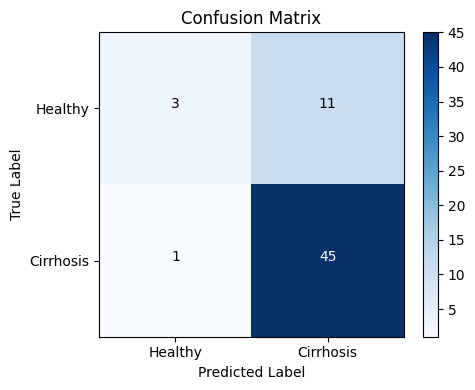

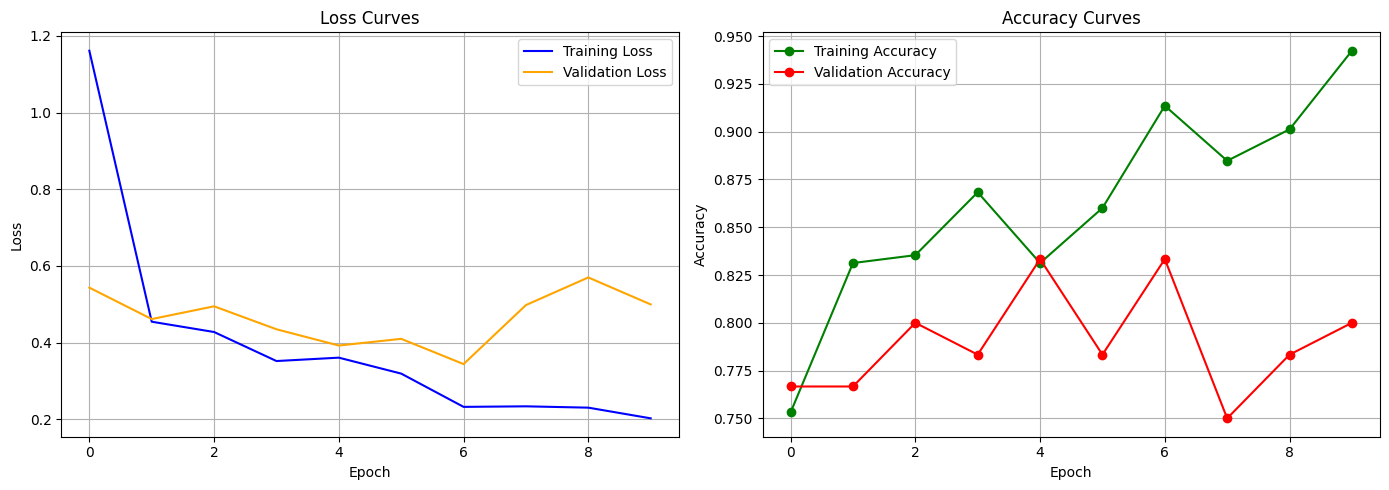

In [8]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for img, meta, label in test_loader:
        img, meta, label = img.to(DEVICE), meta.to(DEVICE), label.to(DEVICE)
        outputs = model(img, meta)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# === Classification Report ===
unique_labels = np.unique(all_labels)
print(f"\nUnique classes in test set: {unique_labels}")
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, 
                            labels=[0, 1], 
                            target_names=['Healthy', 'Cirrhosis'],
                            zero_division=0))

# === Confusion Matrix ===
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Healthy', 'Cirrhosis'])

# === Training Curves ===
plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='red')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


✅ Test Accuracy: 80.00%

=== Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.75      0.21      0.33        14
   Cirrhosis       0.80      0.98      0.88        46

    accuracy                           0.80        60
   macro avg       0.78      0.60      0.61        60
weighted avg       0.79      0.80      0.75        60



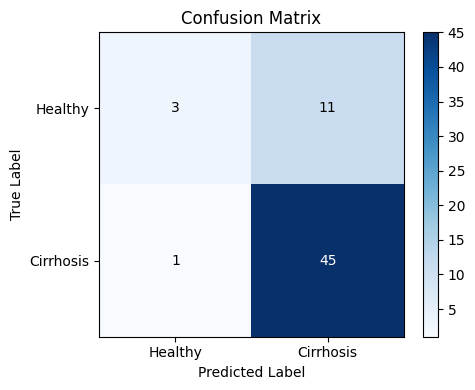

ROC-AUC Score: 0.9022


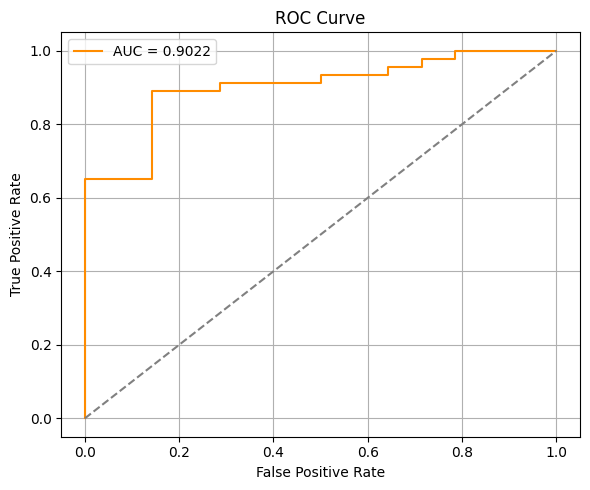

In [9]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# === Load the model ===
model = CNNWithMetadata().to(DEVICE)
model.load_state_dict(torch.load("cirrhosis_cnn_metadata_model.pth"))
model.eval()

# === Inference on test set ===
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for img, meta, label in test_loader:
        img, meta, label = img.to(DEVICE), meta.to(DEVICE), label.to(DEVICE)
        outputs = model(img, meta)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (Cirrhosis)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# === Performance Metrics ===
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {accuracy:.2%}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds,
                            labels=[0, 1],
                            target_names=['Healthy', 'Cirrhosis'],
                            zero_division=0))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['Healthy', 'Cirrhosis'])

# === ROC-AUC Score ===
try:
    auc_score = roc_auc_score(all_labels, all_probs)
    print(f"ROC-AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print("ROC-AUC could not be computed:", e)


NameError: name 'X_test' is not defined